In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 12s 0us/step


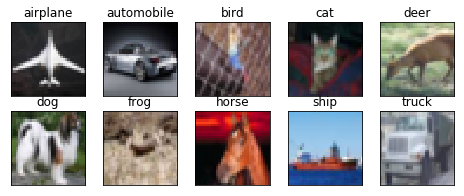

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [7]:
train_features.shape, train_labels.shape,test_features.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [8]:
# Load and Normalize image
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (train_features.mean(), train_features.std(), test_features.mean(), test_features.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# calculate the mean and std on the training dataset
datagen.fit(train_features)
# normalize entire train data set
iterator = datagen.flow(train_features, train_labels, batch_size=len(train_features), shuffle=False)
train_features, train_labels = iterator.next()
# normalize entire test data set
iterator = datagen.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
test_features, test_labels = iterator.next()

print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (train_features.mean(), train_features.std(), test_features.mean(), test_features.std()))

Statistics train=120.708 (64.150), test=121.529 (64.061)
Statistics train=-0.000 (1.000), test=0.013 (0.999)


In [9]:
print(train_labels[1:3])

[[9]
 [9]]


In [10]:
print(test_labels[1:3])

[[8]
 [8]]


In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
train_labels = np_utils.to_categorical(train_labels, 10)
test_labels = np_utils.to_categorical(test_labels, 10)

In [12]:
print(train_labels[1:3])
print(test_labels[1:3])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [13]:
# Define the model
from keras.layers import Activation
model = Sequential()
 
model.add(Convolution2D(32, 3, 3, kernel_regularizer=regularizers.l2(0.0001),border_mode='same',input_shape=(32,32,3))) #3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(64, 3, 3, kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #5
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, 3, kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #7
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(256, 3, 3, kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #9
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))#10

model.add(Convolution2D(32, 1, 1, activation='relu')) #10



model.add(Convolution2D(32, 3, 3, kernel_regularizer=regularizers.l2(0.0001)))#14
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(64, 3, 3, kernel_regularizer=regularizers.l2(0.0001))) #18
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, 3, kernel_regularizer=regularizers.l2(0.0001)))#22
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(256, 3, 3, kernel_regularizer=regularizers.l2(0.0001))) #26
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))#27

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))


model.summary()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg...)`



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


## LR Finder

In [0]:
import SF
from SF import LR_Finder
### LR finding with cutout
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
lr_finder = LR_Finder(start_lr=0.0001, end_lr=0.1, step_size=np.ceil(train_features.shape[0]/128))
#lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/64))
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1))



# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels),
                                 
                                 validation_data = (test_features, test_labels), callbacks=[lr_finder] , verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


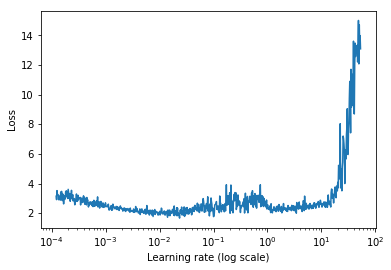

In [0]:
lr_finder.plot()

#### leraning rate=0.1 (lr finder) + CUT OUT + Momentum

In [14]:
from keras.optimizers import SGD
sgd = SGD(lr=0.1,momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`
  del sys.path[0]




Epoch 1/100
390/390 [==============================] - 100s 257ms/step - loss: 2.1960 - acc: 0.2567 - val_loss: 1.9171 - val_acc: 0.3216

Epoch 00001: val_loss improved from inf to 1.91708, saving model to model-001-0.256858-0.321600.h5
Epoch 2/100
390/390 [==============================] - 92s 236ms/step - loss: 1.7245 - acc: 0.3934 - val_loss: 1.5756 - val_acc: 0.4544

Epoch 00002: val_loss improved from 1.91708 to 1.57555, saving model to model-002-0.393427-0.454400.h5
Epoch 3/100
390/390 [==============================] - 92s 236ms/step - loss: 1.5113 - acc: 0.4801 - val_loss: 1.6780 - val_acc: 0.4162

Epoch 00003: val_loss did not improve from 1.57555
Epoch 4/100
390/390 [==============================] - 92s 236ms/step - loss: 1.3208 - acc: 0.5568 - val_loss: 1.5645 - val_acc: 0.4878

Epoch 00004: val_loss improved from 1.57555 to 1.56450, saving model to model-004-0.556765-0.487800.h5
Epoch 5/100
390/390 [==============================] - 92s 235ms/step - loss: 1.1787 - acc: 0

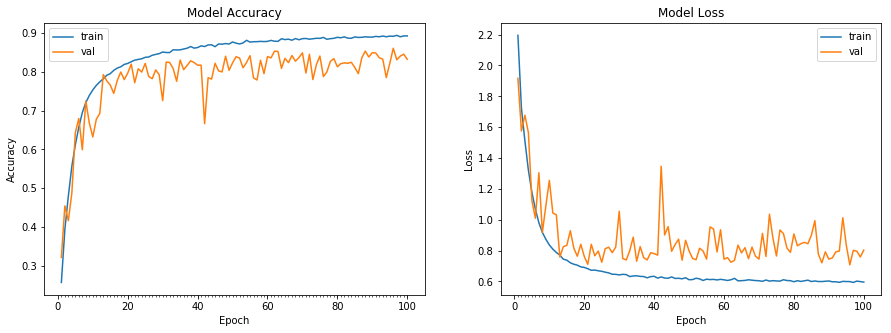

Accuracy on test data is: 83.27


In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks=[checkpoint],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
## using the best model for further work
from keras.models import load_model
model_f = load_model("/content/model-096-0.891983-0.861200.h5")


In [0]:
pred = model_f.predict(test_features)

In [34]:
predicted_class_f = np.argmax(pred, axis=1)
true_class_f = np.argmax(test_labels, axis=1)
num_correct = np.sum(predicted_class_f == true_class_f) 
accuracy = float(num_correct)/pred.shape[0]
print ("Top Accuracy on test data is: %0.2f"%accuracy)    

Top Accuracy on test data is: 0.86


In [25]:
predicted_class

array([3, 8, 8, ..., 5, 1, 7])

In [29]:
true_class

array([3, 8, 8, ..., 5, 1, 7])

## Print the top accuracy

In [30]:
result = model_f.predict(test_features)
actual = np.argmax(test_labels,axis=1)
predicted = 0
for i in range(result.shape[0]):
  pred = result[i].argsort()[-3:][::-1]
  if actual[i] in pred:
    predicted += 1.0
accuracy = (predicted/result.shape[0])*100

print ("Top 3 Accuracy on test data is: %0.2f"%accuracy)    

Top 3 Accuracy on test data is: 97.52


In [31]:
result = model_f.predict(test_features)
actual = np.argmax(test_labels,axis=1)
predicted = 0
for i in range(result.shape[0]):
  pred = result[i].argsort()[-5:][::-1]
  if actual[i] in pred:
    predicted += 1.0
accuracy = (predicted/result.shape[0])*100

print ("Top 5 Accuracy on test data is: %0.2f"%accuracy)    

Top 5 Accuracy on test data is: 99.37


## Finding incorrect instances

In [0]:
incorrect = np.nonzero(predicted_class_f!=true_class_f)[0][:25]

In [68]:
incorrect

array([ 22,  24,  35,  42,  47,  49,  52,  58,  59,  61,  68,  70,  78,
        85,  86, 118, 121, 125, 128, 139, 147, 148, 158, 162, 178])

In [51]:
predicted_class_f[22] , true_class_f[22]

(0, 4)

In [0]:
(train_features1, train_labels1), (test_features1, test_labels1) = cifar10.load_data()

In [53]:
test_labels1[22]

array([4])

## GradeCAM on 25 misclassified images

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

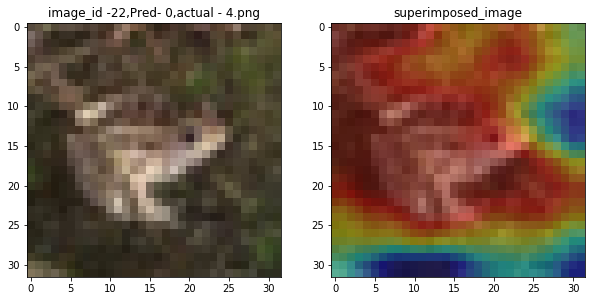

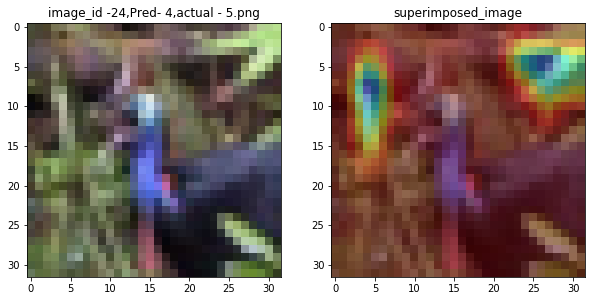

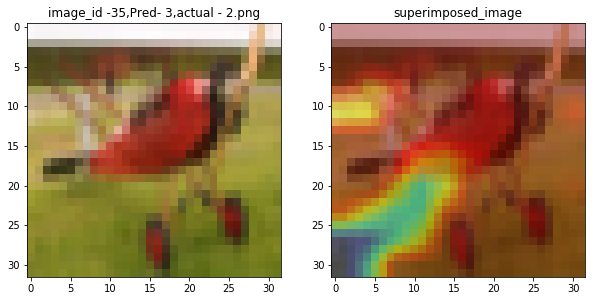

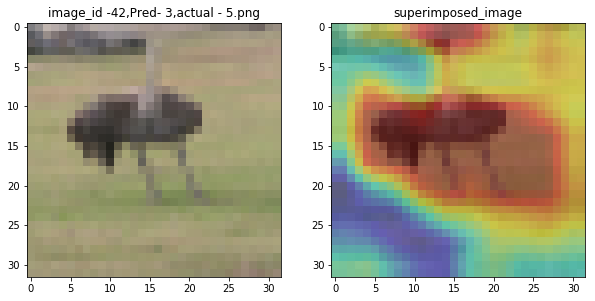

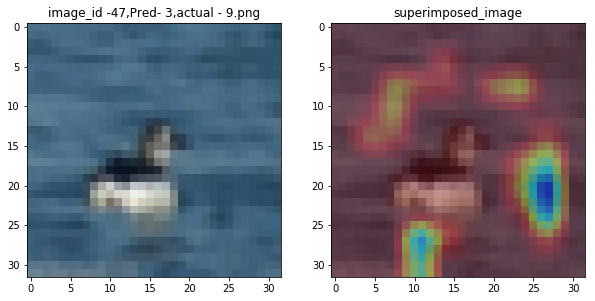

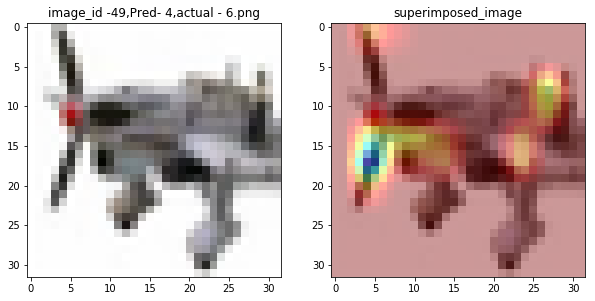

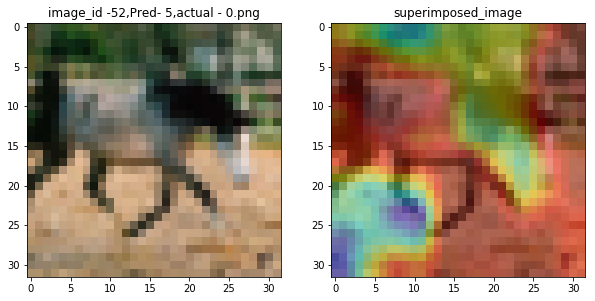

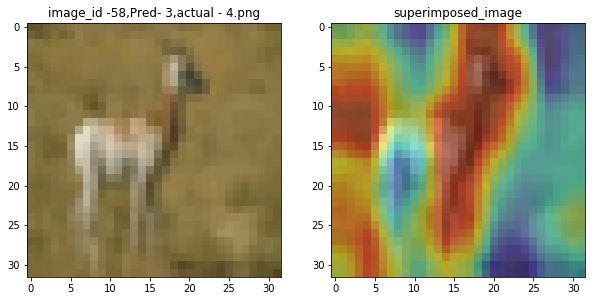

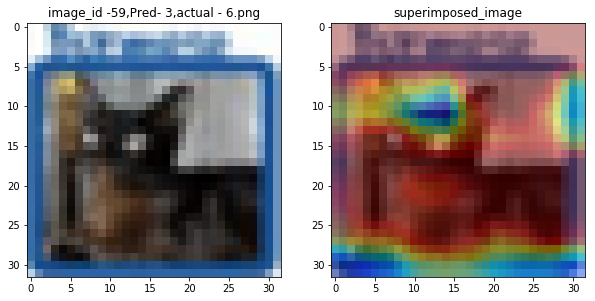

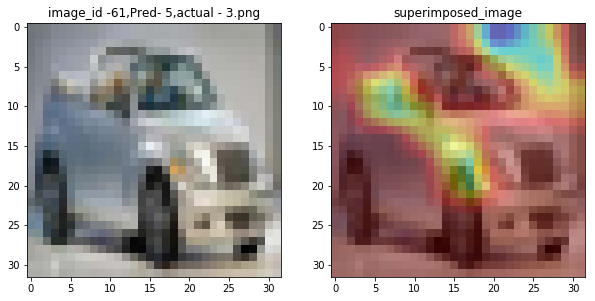

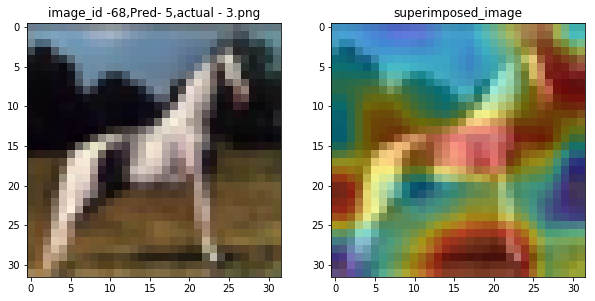

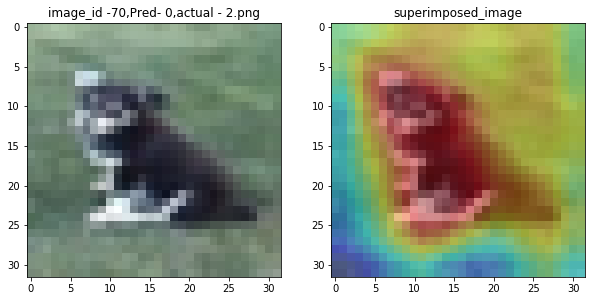

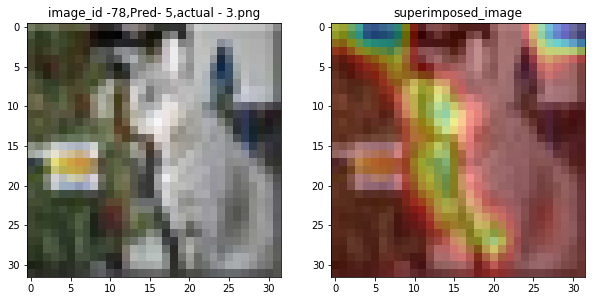

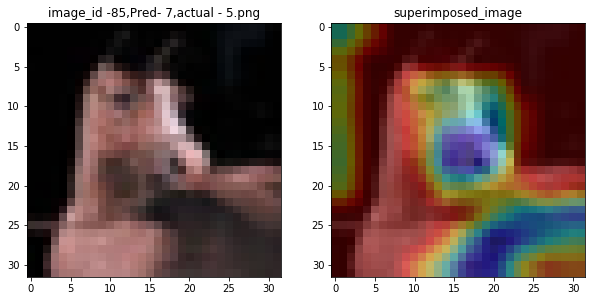

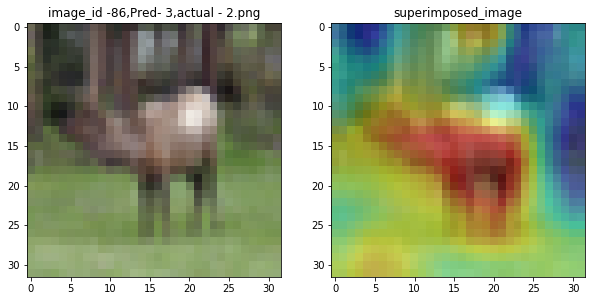

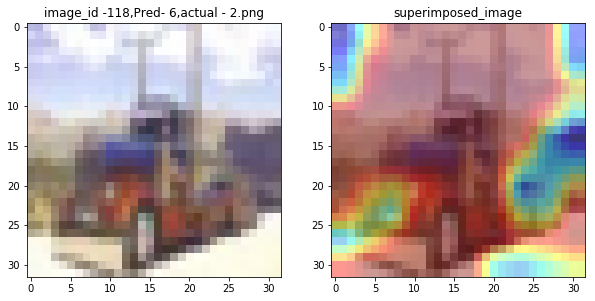

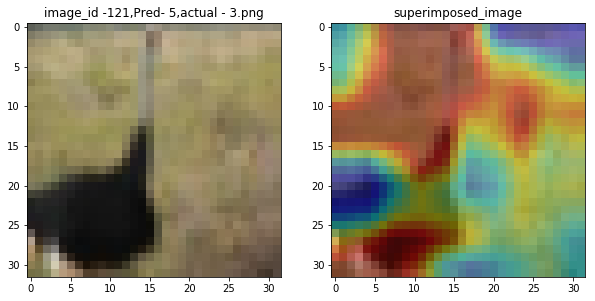

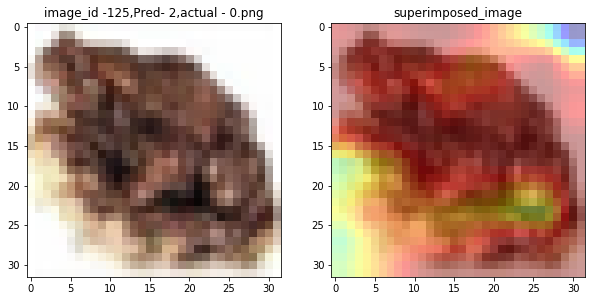

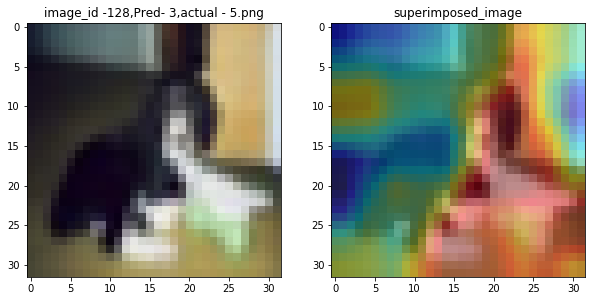

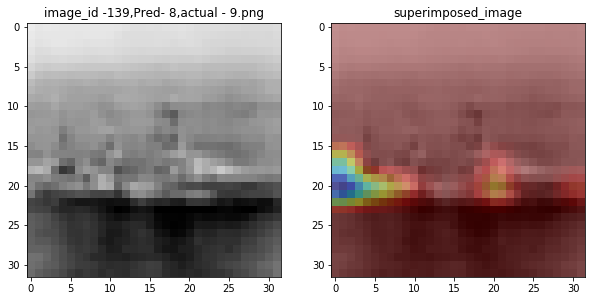

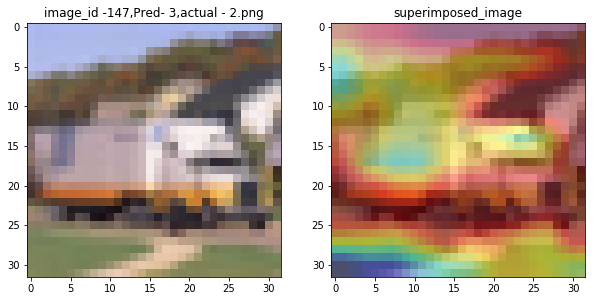

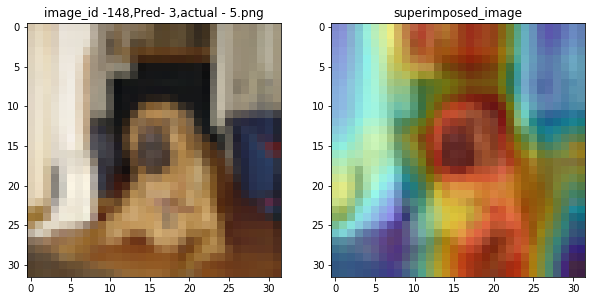

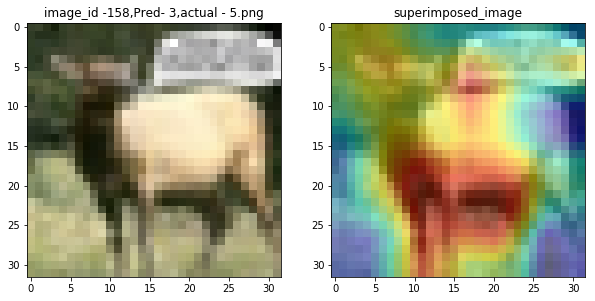

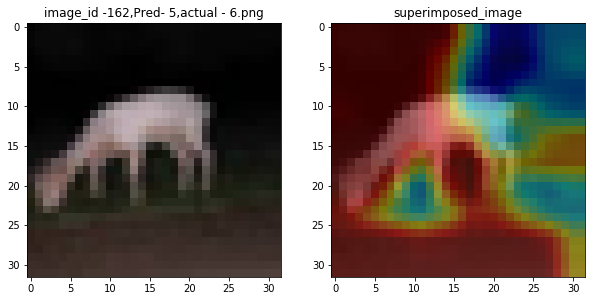

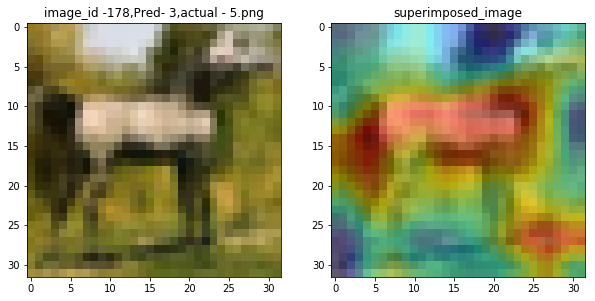

In [67]:
for i in incorrect:
  
  img = train_features1[i]
  x = np.expand_dims(train_features[i], axis=0)
  class_idx = predicted_class_f[i]
  class_output = model_f.output[:, class_idx]
  last_conv_layer = model_f.get_layer("conv2d_8")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model_f.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for k in range(128):
      conv_layer_output_value[:, :, k] *= pooled_grads_value[k]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  fig = plt.figure(figsize=(10,10))
  ax1 = fig.add_subplot(1,2,1)
  ax1.set_title("image_id -{},Pred- {},actual - {}.png".format(i,predicted_class_f[i], true_class_f[i]))
  ax1.imshow(img)
  ax2 = fig.add_subplot(1,2,2)
  ax2.set_title('superimposed_image')
  ax2.imshow(superimposed_img)

  plt.savefig("image_id -{},Pred- {},actual - {}.png".format(i,predicted_class_f[i], true_class_f[i]), bbox_inches='tight')